In [1]:

# Installing transformers package which is implemented/provided by Hugging Face
!pip install transformers==2.6.0
# Now you have access to many transformer-based models including the pre-trained Bert models in pytorch.
!pip install seqeval
!pip install gradio
!pip install kaggle

     |████████████████████████████████| 540 kB 5.3 MB/s 
     |████████████████████████████████| 131 kB 36.2 MB/s 
     |████████████████████████████████| 5.6 MB 17.0 MB/s 
     |████████████████████████████████| 1.2 MB 24.1 MB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
     |████████████████████████████████| 8.0 MB 32.8 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 138 kB 46.9 MB/s 
     |████████████████████████████████| 127 kB 48.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 43 kB 1.0 MB/s 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir '/root/.kaggle'
!chmod 600 '/content/drive/MyDrive/297 2021/kaggle.json'
!cp '/content/drive/My Drive/297 2021/kaggle.json' '/root/.kaggle/'
!kaggle datasets download abhinavwalia95/entity-annotated-corpus 
!unzip entity-annotated-corpus.zip

 49% 13.0M/26.4M [00:00<00:00, 131MB/s]
100% 26.4M/26.4M [00:00<00:00, 128MB/s]
Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


In [4]:
import pandas as pd
import numpy as np

# This is for the loading bar I think
from tqdm import tqdm, trange

data = pd.read_csv("ner_dataset.csv", encoding="latin1").fillna(method="ffill")

# ffill will update missing data with last valid observation

In [5]:

data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [6]:
# This will take the dataset and group the words that belong in the same sentence together.
class SentenceGetter(object):

  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    self.empty = False
    
    # Creating a triplet with the word , post and tag. Zip used since each array is equal length and are corresponding to one another
    agg_func = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(), s['Tag'].values.tolist())]
    
    # Grouping sentences by Sentence # 
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    
    # 0 index is the words, 1 is the pos, 2 is the tag
    self.sentences = [s for s in self.grouped]
  
  # Helps get the next sentence from the SentenceGetter object
  def get_next(self):
    try:
      s = self.grouped["Sentence {} ".format(self.n_sent)]
      self.n_sent = self.n_sent + 1
      return s
    except:
      return None

In [7]:

getter = SentenceGetter(data)

In [8]:

sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [9]:
# Additionally we can get the labels for each word in the sentence
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [10]:

# This I think is used for classification of the NER model
tag_values = list(set(data["Tag"].values))
# PAD might be explained later on why this is added.
tag_values.append("PAD")
tag2idx = {t : i for i, t in enumerate(tag_values)}
tag2idx

{'B-art': 2,
 'B-eve': 13,
 'B-geo': 3,
 'B-gpe': 8,
 'B-nat': 1,
 'B-org': 0,
 'B-per': 7,
 'B-tim': 6,
 'I-art': 9,
 'I-eve': 11,
 'I-geo': 5,
 'I-gpe': 10,
 'I-nat': 12,
 'I-org': 14,
 'I-per': 15,
 'I-tim': 16,
 'O': 4,
 'PAD': 17}

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.9.0+cu111'

In [12]:
# Limiting sequence length to 75 tokens
MAX_LEN = 75 

# Batch size of 32
bs = 32

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [14]:

torch.cuda.get_device_name(0)

'Tesla K80'

In [15]:
# This tokenizer is well suited for NER
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [16]:
def tokenize_and_preserve_labels(sentence, text_labels):
  tokenized_sentence = []
  labels = []

  for word, label in zip(sentence, text_labels):

    # Tokenize word and count the number of subwords the word is broken 
    # into
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)

    # Add tokenized word to word list
    tokenized_sentence.extend(tokenized_word)

    # Same label being applied to all subwords 
    labels.extend([label] * n_subwords)
  
  return tokenized_sentence, labels

In [17]:
tokenized_texts_labels = [tokenize_and_preserve_labels(sentence, label) for sentence, label in zip(sentences, labels)]

In [18]:
print (tokenized_texts_labels[0])

(['Thousands', 'of', 'demons', '##tra', '##tors', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'])


In [19]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_labels]

In [20]:

# cutting and padding tokens and label sequences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) 
  for txt in tokenized_texts], maxlen=MAX_LEN, 
    dtype="long", value=0.0, truncating="post", padding="post")
print (input_ids)

[[26159  1104  8568 ...     0     0     0]
 [ 7239  3878  1474 ...     0     0     0]
 [ 1124  8031  4184 ...     0     0     0]
 ...
 [ 2485  3398   112 ...     0     0     0]
 [ 1967  1173   117 ...     0     0     0]
 [ 1109  1244  3854 ...     0     0     0]]


In [21]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels], maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post", dtype="long", truncating="post")
print (tags)

[[ 4  4  4 ... 17 17 17]
 [ 8  4  4 ... 17 17 17]
 [ 4  4  4 ... 17 17 17]
 ...
 [ 4  3  4 ... 17 17 17]
 [ 4  4  4 ... 17 17 17]
 [ 4  0 14 ... 17 17 17]]


In [22]:
# Mask to ignore padded elements
attention_masks = [[float(i != 0.0) for i in input_id] for input_id in input_ids]

In [23]:

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [24]:

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [25]:

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [26]:

import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'2.6.0'

In [27]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [28]:
# passing model params to the gpu
model.cuda()


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [29]:
# Before finetuning we need to add optimizers and add params 
# the model should update
FULL_FINETUNING = True

if FULL_FINETUNING: 
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
    {'params' : [p for n, p in param_optimizer if not any (nd in n for nd in no_decay)],
     'weight_decay_rate' : 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
  ]
else:
  param_optimizer = list(model.classifier.named_parameters())
  optimizer_grouped_parameters = [{"params" : [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [30]:
# Adding a linear scheduler to reduce learning rate with each epoch

from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Training steps = number of batches * number of epochs

total_steps = len(train_dataloader) * epochs

# Creating scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [31]:
# Metrics 
from seqeval.metrics import f1_score, accuracy_score

In [32]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Average train loss: 0.1904965550165825


Epoch:  33%|███▎      | 1/3 [19:42<39:24, 1182.41s/it]

Validation loss: 0.14059349032739799
Validation Accuracy: 0.9560291163005171
Average train loss: 0.10908168835981057
Validation loss: 0.12591643350819748


Epoch:  67%|██████▋   | 2/3 [39:22<19:41, 1181.14s/it]

Validation Accuracy: 0.9612331609630776
Average train loss: 0.08190551861082297
Validation loss: 0.1297708962733547


Epoch: 100%|██████████| 3/3 [58:56<00:00, 1178.75s/it]

Validation Accuracy: 0.9619001350416653


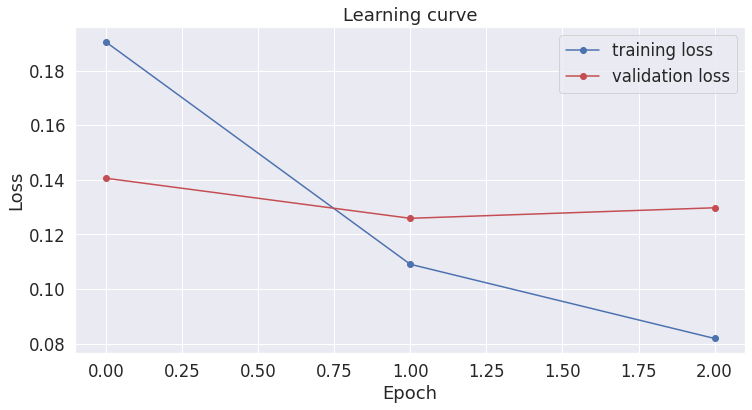

In [33]:
!pip install matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns

# Styling from seaborn for graph
sns.set(style='darkgrid')

# Increase plot/font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot learning curve
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# label the plot
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [35]:
import gradio as gr

def greet(input_sentence):
  tokenized_sentence = tokenizer.encode(input_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)
  final_string_result = ""
  for token, label in zip(new_tokens, new_labels):
    final_string_result = final_string_result + token + " [" + label + "] "
  return final_string_result
iface = gr.Interface(fn=greet, inputs="text", outputs="text")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://19567.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://19567.gradio.app')